In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime

In [2]:
# load data, skip header row
data = np.loadtxt('../large_files/train.csv', delimiter=',', skiprows=1, dtype=int)

In [3]:
def set_up_data(d):
    # shuffle the data
    np.random.shuffle(d)

    # split into X and Y (labels are first column)
    X = d[:, 1:]
    Y = d[:, 0]

    # split into train/test
    r, c = np.shape(d)
    r_90 = r // 90
    X_train, X_test = X[:-r_90], X[-r_90:]
    Y_train, Y_test = Y[:-r_90], Y[-r_90:]

    # normalize.
    # takes mean/std for each col (??)
    mu = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    
    # for all-black images (std == 0), change std to 1 to prevent /0 errors
    idx = np.where(std == 0)[0]
    assert(np.all(std[idx]) == 0)

    np.place(std, std == 0, 1)

    X_train = (X_train - mu) / std
    X_test = (X_test - mu) / std
    
    return X_train, X_test, Y_train, Y_test

In [4]:
def onehot_encode(y):
    N = len(y)
    min_y, max_y = np.min(y), np.max(y)
    K = (max_y - min_y) + 1

    encoded_y = np.zeros((N, K))

    for i in range(N):
        col_val = y[i]
        encoded_y[i, col_val] = 1
    
    return encoded_y


In [5]:
def forward(x, W, b, y_encode, y):
    a = np.dot(x, W) + b

    # softmax the outputs
    expa = np.exp(a)
    Y_pred = expa / (np.sum(expa, axis=1, keepdims=True))

    # calc loss
    tot = y_encode * np.log(Y_pred)
    loss = -tot.sum()
    
    # calc err
    # first create an array of bools. 
    # True when the argmax of your prediction equals the real y
    # Then use np.mean to get an average of all 0s (Falses) and 1s (Trues)
    err = np.mean(np.argmax(Y_pred, axis=1) != y)

    return loss, err, Y_pred

In [6]:
def weight_gradients(x, y, y_pred):
    W_grad = x.T.dot(y - y_pred)
    b_grad = (y - y_pred).sum(axis=0)

    return W_grad, b_grad

In [120]:
# this isn't really finished, but it works fine

def linear_regression_batches(batch_size):
    X_train, X_test, Y_train, Y_test = set_up_data(data)

    # n is num samples, D is num features
    N, D = X_train.shape

    # one-hot encode Ys
    Y_train_encode = onehot_encode(Y_train)
    Y_test_encode = onehot_encode(Y_test)
    K = Y_test_encode.shape[1]
    
    # randomly initialize weights, start with 0 bias terms
    W = np.random.randn(D, K) / np.sqrt(D)
    b = np.zeros(K)


    train_losses, test_losses = [], []
    train_errors, test_errors = [], []

    # lr was increased in this section, but then gradients were divided by N, so... ? not sure why we did this exactly
    lr = 0.9
    reg = 0.0
    num_iters = 100
    num_batches = int(np.ceil(N / batch_size))

    # now plotting after every 5 sec
    t0 = datetime.now()
    t0_copy = t0
    t0_graph = t0

    for i in range(num_iters):
        # print(i)
        for j in range(num_batches):

            # split training data into batches
            X_train_split = X_train[(j * batch_size):((j+1) * batch_size)]
            Y_train_split = Y_train[(j * batch_size):((j+1) * batch_size)]
            Y_train_encode_split = Y_train_encode[(j * batch_size):((j+1) * batch_size)]

            # err, loss = forward(x, W, b, y_encode, y)
            train_loss, train_err, train_pred = forward(X_train_split, W, b, Y_train_encode_split, Y_train_split)
        
            # update weights using gradient ascent (decent)
            W_grad, b_grad = weight_gradients(X_train_split, Y_train_encode_split, train_pred)
            W_grad /= N
            b_grad /= N
            W += lr * (W_grad - (reg*W))
            b += lr * b_grad

            if (datetime.now() - t0_graph).total_seconds() > 0.5:
                train_losses.append(train_loss)
                train_errors.append(train_err)
                test_loss, test_err, test_pred = forward(X_test, W, b, Y_test_encode, Y_test)
                test_losses.append(test_loss)
                test_errors.append(test_err)

                t0_graph = datetime.now()
            
            if (datetime.now() - t0).total_seconds() > 5:
                # print(f'Iter {i} / {num_iters}')
                print(f'Train err: {train_err}')
                print(f'Test err: {test_err}')

                x = list(range(1, len(train_losses) + 1))
                plt.plot(x, train_errors, x, test_errors)
                plt.show()

                t0 = datetime.now()
            
            if (datetime.now() - t0_copy).total_seconds() > 30:
                print(f'Final train err: {train_err}')
                print(f'Final test err: {test_err}')

                x = list(range(1, len(train_losses) + 1))
                plt.plot(x, train_errors, x, test_errors)
                plt.show()
                return test_errors, test_losses

    
    print(f'Final train err: {train_err}')
    print(f'Final test err: {test_err}')

    x = list(range(1, len(train_losses) + 1))
    plt.plot(x, train_errors, x, test_errors)
    plt.show()

    return test_errors, test_losses

Train err: 0.0805845813068811
Test err: 0.08798283261802575


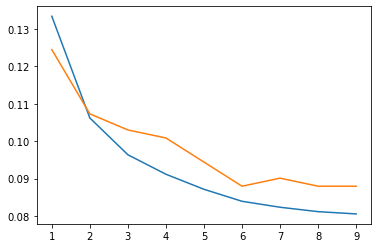

Train err: 0.0738431164828815
Test err: 0.0815450643776824


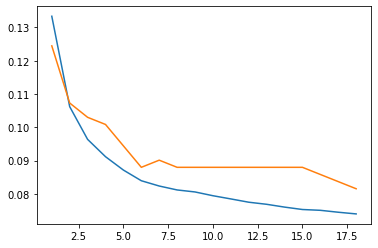

Final train err: 0.0714113738142245
Final test err: 0.07939914163090128


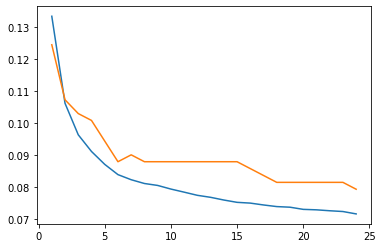

In [121]:
errors_full, losses_full = linear_regression_batches(batch_size=100000)

Train err: 0.086
Test err: 0.09012875536480687


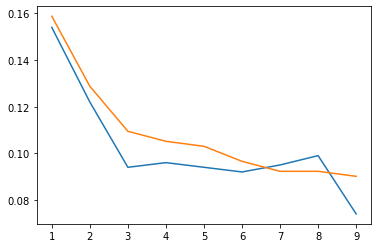

Train err: 0.079
Test err: 0.08583690987124463


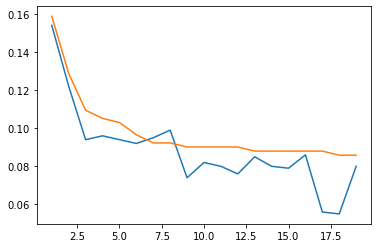

Train err: 0.067
Test err: 0.08583690987124463


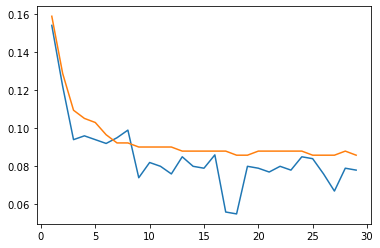

Final train err: 0.09363295880149813
Final test err: 0.08798283261802575


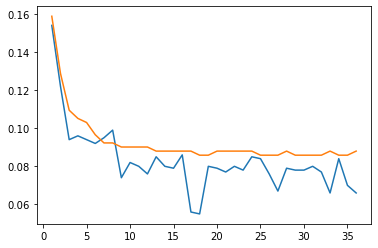

In [122]:
errors_100, losses_100 = linear_regression_batches(batch_size=1000)

Train err: 0.0
Test err: 0.3626609442060086


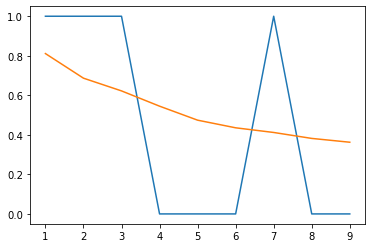

Train err: 0.0
Test err: 0.30472103004291845


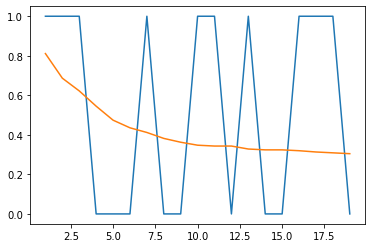

Train err: 0.0
Test err: 0.2510729613733906


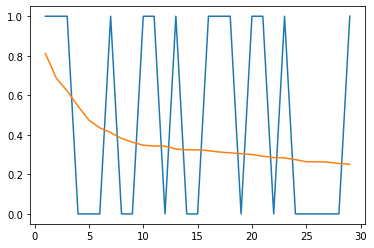

Train err: 0.0
Test err: 0.22532188841201717


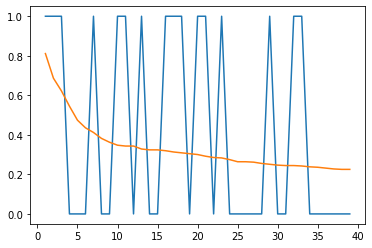

Train err: 0.0
Test err: 0.19527896995708155


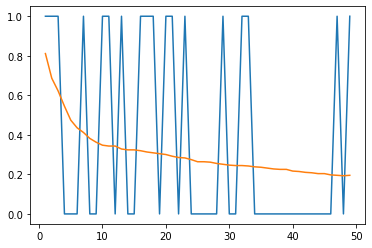

Final train err: 0.0
Final test err: 0.18454935622317598


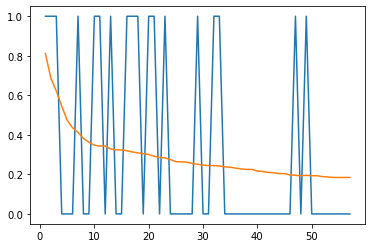

In [123]:
errors_sgd, test_losses_sgd = linear_regression_batches(batch_size=1)